# Data Vis and Analysis on the LeaderBoard
## OR: Why is there a negative relationship between FNC and 3M, 1Y returns?

Hi everybody I'm MRQUANTSALOT and created this notebook in order to figure out if participating in this tournement the type of challenge I had a reasonable shot at being successful at. Towards that end, I looked at the characteristics and distribution of successful users. My conclusion is that I think I have a reasonable shot at being profitable. 

If you have any feedback or suggestions please let me know in this forum post "link to forum". I am still a novice at this kind of anaylsis and I am sure there are things that I missed or misinterperated. In particicular, I don't know why there is a negative coefficent on the FNC-> 3M_returns regression. 

This notebook does the following when you run it.

1. Query the [Numerai Leaderboard](https://numer.ai/tournament) and cast it as a Pandas Dataframe.
2. Visualize the relationship between the stake size, performace metrics and returns. 
3. OLS Regression on Returns.  

All of the methods are written such that you can change the dependent and independent varibles. I included the visualizations I thought were the interesting but you can check out the other variables yourself.

In [2]:
!pip install numpy
!pip install pandas 
!pip install json 
!pip install requests 
!pip install matplotlib
!pip install statsmodels 
%matplotlib inline

You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json
You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\parke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


# Import packages

In [3]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Ping the Leaderboard

In [4]:
def get_leaderboard() -> pd.DataFrame:
    """
        Ping the Numerai leaderboard and return a Pandas DataFrame of the contents.
        https://numer.ai/tournament

    """
    url = 'https://api-tournament.numer.ai/'
    # this is a Qraph QL query, that lets me get exaclty and only the data I want. 
    query = """{ 
	v2Leaderboard {
	    returns
        corrRep
        fncRep
        mmcRep
        username
        nmrStaked
        returns 
        return_52Weeks
        return_13Weeks
        rank
	    }  
    }"""
    r = requests.post(url=url, json={'query': query})
    json_data = json.loads(r.text)
    df_data = json_data['data']['v2Leaderboard']
    df = pd.DataFrame(df_data)
    df.convert_dtypes() # the auto casts the columns into what it thinks is the most appropriate 
    df['nmrStaked'] = pd.to_numeric(df['nmrStaked'])

    # I am renaming the columns
    df = df.rename(columns={'returns': '1D_returns', 'return_13Weeks': '3M_returns', 'return_52Weeks': '1Y_returns'})
    return df

df =  get_leaderboard()
print(df.count())
df.head()


corrRep       5126
fncRep        5126
mmcRep        5126
nmrStaked     5126
rank          5126
3M_returns    1871
1Y_returns     398
1D_returns    2395
username      5126
dtype: int64


,corrRep,fncRep,mmcRep,nmrStaked,rank,3M_returns,1Y_returns,1D_returns,username
0,0.051317,0.012655,0.023534,775.855097,1,154.676723,NaN,-3.529810,quantyquant
1,0.049374,0.007667,0.022452,931.557869,2,161.393898,519.608612,2.731775,benben11
2,0.046950,0.023869,0.019093,95.382757,3,49.330328,204.339806,-4.489362,labrat
3,0.042120,0.016383,0.023607,0.012556,4,NaN,NaN,-1.832958,hb_falcon
4,0.041836,0.015358,0.017292,0.000000,5,NaN,NaN,1.043646,uuazed4


# Methods to create plots

### Each method has the optional param min_stake. Use it to exclude smaller stakeing users. 


In [5]:
def create_box_plot(df, col='corrRep', min_stake=0):
    x = df[(df[col].notnull()) & (df['nmrStaked'] > min_stake)][col]
    plt.boxplot(x, vert=False)
    num_elements = x.count()
    plt.title(
        f'Distribution of {col} nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    plt.xlabel(col)
    return plt


def create_scatter_plot(df, x_name='corrRep', y_name='fncRep', min_stake=0, max_stake=1000000):

    # these are kind of ugly one liners if you are unfamiler with pandas.
    # They select a subset of on the Dataframe df based on a compound booleans. Think of them as SELECT x_name WHERE ... if you were writing SQL
    # (df[x_name].notnull()) says only give me the rows when x_name is not null
    # df['nmrStaked'] > min_stake) only give me the rows where the stake is greater than the min_stake
    # df['nmrStaked'] < max_stake) only give me the rows wehre the stake is less than the max stake.abs
    # [x_name] says only give me the column with name x_name
    x = df[((df[x_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][x_name]
    y = df[((df[y_name].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][y_name]
    plt.scatter(x, y, s=.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    num_elements = x.count()
    plt.title(
        f'{y_name} v {x_name} when nmrStaked>{min_stake}\n Number of Elements:{num_elements}'
    )
    return plt


def create_histogram(df, col='corrRep', bins=20, min_stake=0, max_stake=1000000):
    x = df[((df[col].notnull()) & (df['nmrStaked'] > min_stake)) & (df['nmrStaked'] < max_stake)][col]
    plt.hist(x, bins, label=f'{col} when nmrStaked>{min_stake}', alpha=.5)
    plt.xlabel(col)
    plt.ylabel('Count')
    num_elements = x.count()    
    return plt

plt.rcParams["figure.figsize"] = (6,6)

## Histogram of 3 Month Returns by Stake Size

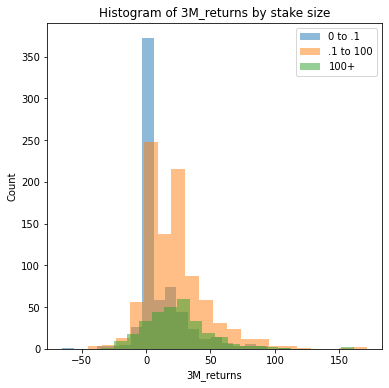

In [6]:
col = '3M_returns' # change this to be '1D_returns' or '1Y_returns' or 'corrRep', 'fncRep' to see other distributions

create_histogram(df,col=col, min_stake=0, max_stake=.1)
create_histogram(df,col=col, min_stake=.1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['0 to .1','.1 to 100','100+'])
plt.title(f'Histogram of {col} by stake size')
plt.show()

## Histogram of 3 Month returns excluding where stake is < .1

### This excludes everyone that is only betting the free .01 NMR given out. Staking .1 NMR is only about $4 right now so it is not much of a cut off. You can change up these values is reduce who you are looking at. 



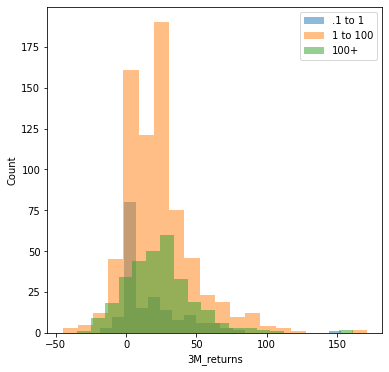

In [7]:
col = '3M_returns'

create_histogram(df,col=col, min_stake=0.1, max_stake=1)
create_histogram(df,col=col, min_stake=1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 1','1 to 100','100+'])
plt.show()

## Histogram of Corr by Stake Size

- This forms a bimodal distribution at corrRep = -.1 and corrRep = ~+.025 

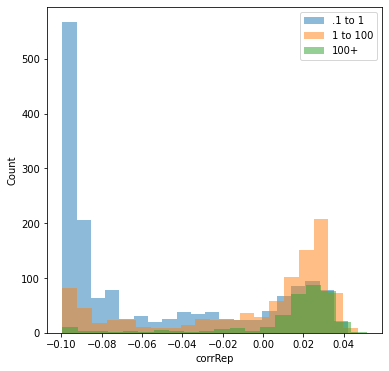

In [17]:
col = 'corrRep'

create_histogram(df,col=col, min_stake=0, max_stake=1)
create_histogram(df,col=col, min_stake=1, max_stake=100)
create_histogram(df, col=col,min_stake=100, max_stake=1000000)

plt.legend(['.1 to 1','1 to 100','100+'])
plt.show()

# Scatter Plots


<module 'matplotlib.pyplot' from 'C:\\Users\\parke\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python39\\site-packages\\matplotlib\\pyplot.py'>

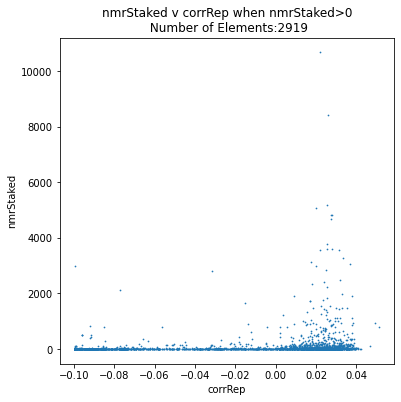

In [8]:
create_scatter_plot(df, x_name='corrRep', y_name='nmrStaked')

# Methods to for Ordinary Least Squares Regresssion

## [Read about OLS on Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares)
### I am primairly interested in the relationship between stake size and returns. From an Economics perspective one would expect people to bet more money on models that have a better higher corrilation score. This would mean a positive corrilation between stake size and returns. 

In [9]:
def compute_single_regression(df,
                              independent_variable='corrRep',
                              dependent_variable='3M_returns',
                              min_stake=0):

    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][independent_variable]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


def compute_multiple_regression(
        df,
        indepenent_variables=['corrRep', 'fncRep', 'mmcRep', 'nmrStaked'],
        dependent_variable='3M_returns',
        min_stake=0):
    x = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][indepenent_variables]
    y = df[(df[dependent_variable].notnull())
           & (df['nmrStaked'] > min_stake)][dependent_variable]
    model = sm.OLS(y, x)
    results = model.fit()
    return results


## Single Regression Stake Size and 3 Month Returns

In [10]:
results = compute_single_regression(df,independent_variable='nmrStaked',dependent_variable='3M_returns', min_stake=0)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.027
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              50.92
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    1.37e-12
Time:                        09:33:37   Log-Likelihood:                         -8971.9
No. Observations:                1870   AIC:                                  1.795e+04
Df Residuals:                    1869   BIC:                                  1.795e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nmrStaked      0.0089      0.001      7.136      0.000       0.006       0.011
==============================================================================
Omnibus:                      539.981   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2061.050
Skew:                           1.370   Prob(JB):                         0.00
Kurtosis:                       7.353   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Findings

## There is a small significant positive relationship between amount staked and 3 Month returns (coef= 0.0086, p<.000). However, only looking at stake size does not explain much of the varience in the 3 Month Returns. 

- The R^2 value is .027, I thought this would be much larger.
- One explanation is that having access to a lot of capital to stake is not indicitive of being good at model building. 
- There are a lot of low captial high skill data scientists out there

## Multiple Regression on 1D returns. 

### This is looking at the relative impact of CORR, MMC, FNC, and Stake on returns. Because this is only 1D returns one would expect a these features to poorly predict returns because there is so much varience in 1D returns. 

In [11]:
# mutiple regression looks at the impact of multiple independent varibles on the dependent variable.
# I set the default independent variables to ['corrRep', 'fncRep', 'mmcRep', 'nmrStaked']
results = compute_multiple_regression(df,dependent_variable='1D_returns')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1D_returns   R-squared (uncentered):                   0.062
Model:                            OLS   Adj. R-squared (uncentered):              0.061
Method:                 Least Squares   F-statistic:                              39.11
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                    9.55e-32
Time:                        09:33:37   Log-Likelihood:                         -6259.7
No. Observations:                2364   AIC:                                  1.253e+04
Df Residuals:                    2360   BIC:                                  1.255e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep      -32.4810      6.574     -4.941      0.000     -45.373     -19.589
fncRep       142.5913     12.806     11.135      0.000     117.480     167.703
mmcRep      -113.5449      9.180    -12.369      0.000    -131.546     -95.544
nmrStaked  -8.775e-05      0.000     -0.584      0.559      -0.000       0.000
==============================================================================
Omnibus:                      233.367   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.079
Skew:                           0.549   Prob(JB):                    3.70e-135
Kurtosis:                       5.254   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


## Multiple Regression on 3 Month Returns

In [12]:
results = compute_multiple_regression(df,dependent_variable='3M_returns')
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             3M_returns   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              1624.
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                        0.00
Time:                        09:33:37   Log-Likelihood:                         -7594.6
No. Observations:                1870   AIC:                                  1.520e+04
Df Residuals:                    1866   BIC:                                  1.522e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     2312.1465     30.319     76.262      0.000    2252.685    2371.609
fncRep     -2831.4717     59.606    -47.503      0.000   -2948.373   -2714.571
mmcRep       522.5655     39.944     13.082      0.000     444.225     600.906
nmrStaked      0.0002      0.001      0.286      0.775      -0.001       0.001
==============================================================================
Omnibus:                      496.004   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3451.698
Skew:                           1.060   Prob(JB):                         0.00
Kurtosis:                       9.309   Cond. No.                     1.22e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Regression on 1 Year returns

In [13]:
results = compute_multiple_regression(df, dependent_variable='1Y_returns')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             1Y_returns   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.839
Method:                 Least Squares   F-statistic:                              516.7
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                   5.13e-155
Time:                        09:33:37   Log-Likelihood:                         -2242.0
No. Observations:                 397   AIC:                                      4492.
Df Residuals:                     393   BIC:                                      4508.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
corrRep     7987.8764    338.712     23.583      0.000    7321.961    8653.791
fncRep     -1170.1844    685.540     -1.707      0.089   -2517.969     177.601
mmcRep     -6881.3038    444.825    -15.470      0.000   -7755.837   -6006.770
nmrStaked      0.0135      0.004      3.506      0.001       0.006       0.021
==============================================================================
Omnibus:                       46.705   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.468
Skew:                           0.659   Prob(JB):                     5.05e-21
Kurtosis:                       4.978   Cond. No.                     2.43e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# What do the long term profits look like?

In [15]:
users_with_3_month_returns = df[df['3M_returns'].notnull()]['3M_returns']
num_3M_returns = users_with_3_month_returns.count()

print('Discription users with 3 months of returns\n', users_with_3_month_returns.describe())

users_net_postive_3_month_returns = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 0)]['3M_returns']
num_net_postitive = users_net_postive_3_month_returns.count()

percent_net_positive = "{:.1%}".format(num_net_postitive/num_3M_returns)

print(f'Users who were net postive over 3 months: {percent_net_positive}')

users_net_up_10_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 10)]['3M_returns']
num_net_up_10_percent = users_net_up_10_percent.count()

percent_net_up_10 = "{:.1%}".format(num_net_up_10_percent/num_3M_returns)
print(f'Users who were net up 10% over 3 months: {percent_net_up_10}')

users_net_up_50_percent = df[(df['3M_returns'].notnull()) & (df['3M_returns'] > 50)]['3M_returns']
num_net_up_50_percent = users_net_up_50_percent.count()

percent_net_up_50 = "{:.1%}".format(num_net_up_50_percent/num_3M_returns)
print(f'Users who were net up 50% over 3 months: {percent_net_up_50}')


Discription users with 3 months of returns
 count    1871.000000
mean       17.886077
std        23.750622
min       -64.817097
25%         0.000000
50%        13.372656
75%        28.048466
max       171.204201
Name: 3M_returns, dtype: float64
Users who were net postive over 3 months: 66.8%
Users who were net up 10% over 3 months: 54.2%
Users who were net up 50% over 3 months: 9.2%


# Conclusions

1. I was suprised that there is a negative relationship between FNC and 3M and 1Y returns. I would have expected each of those paramaters to have positive coefficients. 
2. The R^2 increases when you look at larger time frames. This matches intutition and the law of large numbers. As you increase the time period you consider, the randomness in the 1D and 3M returns will tend to even out. 
3. Because some people might have mutiple accounts, there is a upperbound of ~900 people who have successfullly build models to forcast the stock market well enough to get net +10% doing it. That is absolutly incredible. 
4. Because there is such a small relationship between Stake Size and returns I can conclude that you don't need access to large amounts of capital to build a good model. If you look at the leaderboard right now, there people there are people who have staked anywhere from 0 to ~1,000 NMR that are doing comperably well.
5. It seems like betting any amount of money on your model
